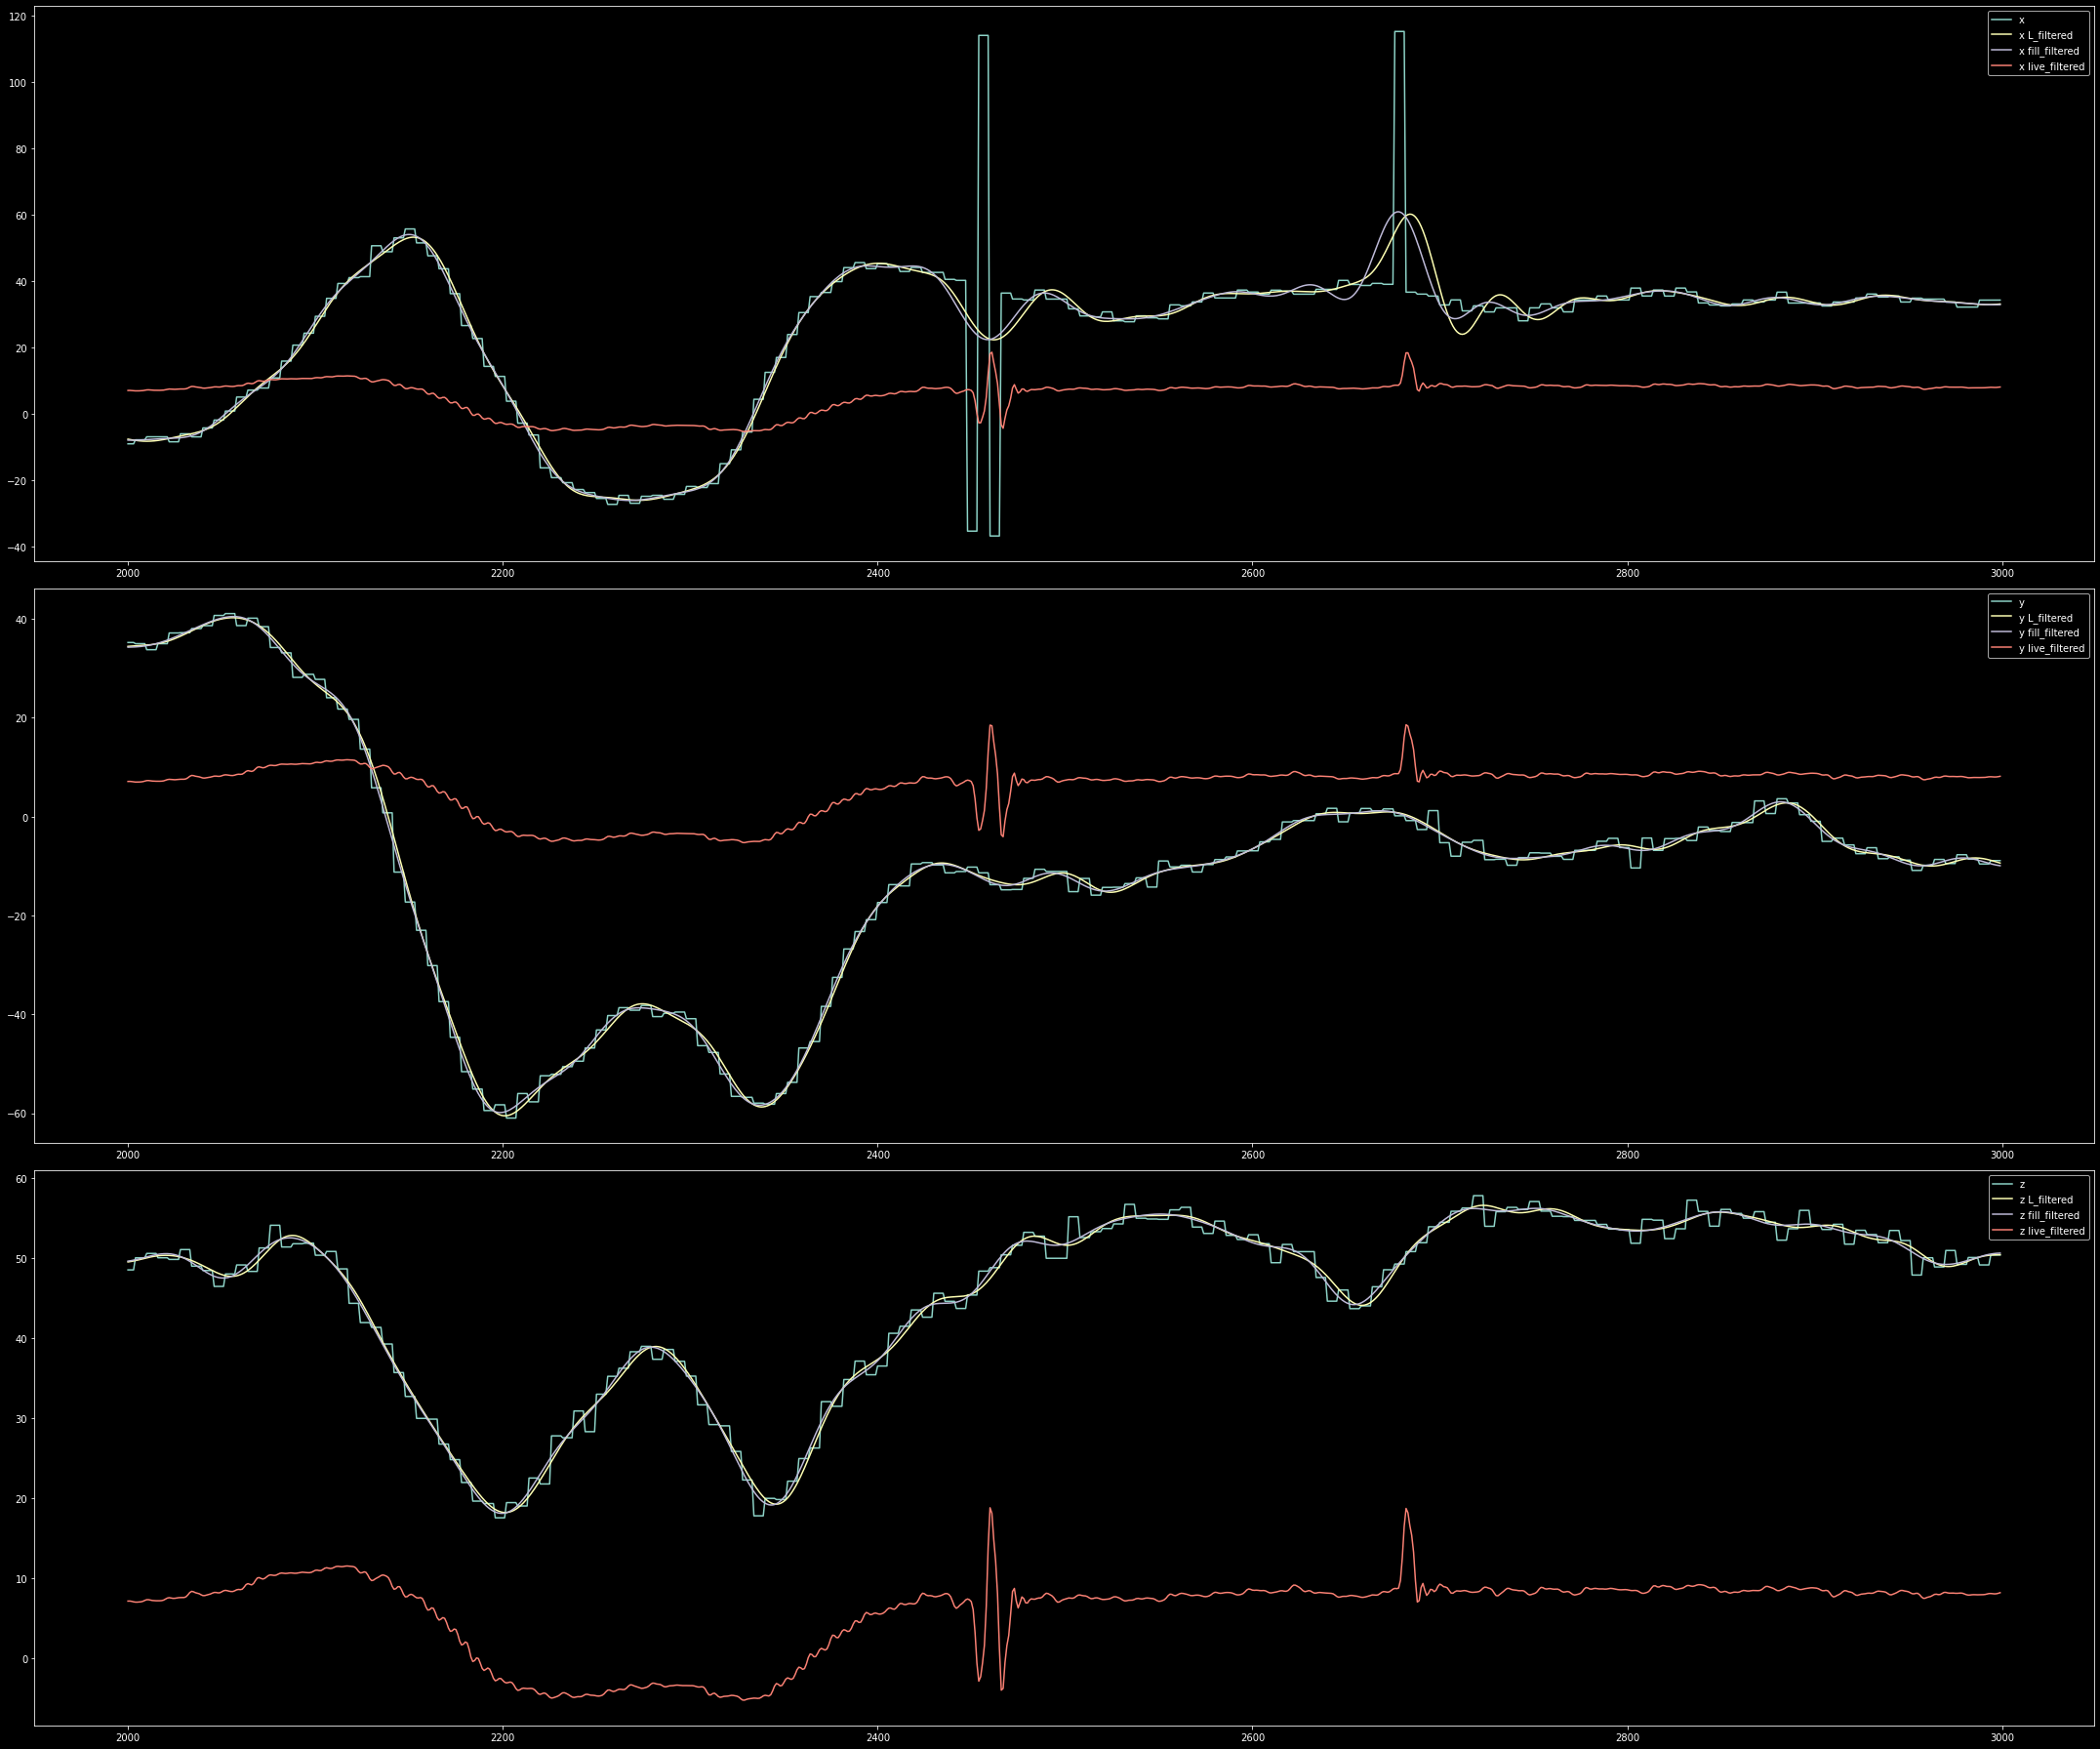

In [32]:
import matplotlib.pyplot as plt
from scipy import signal
from PDR.util import LiveLFilter
import pandas as pd

b, a = signal.butter(10, 5, fs=200, btype='lowpass', analog=False)
live_lfilter = LiveLFilter(b, a)


df = pd.read_csv('data.csv', index_col=[0], header=[0,1]).reset_index(drop=True)
df = df['mag']
df_f = pd.read_csv('data_f.csv', index_col=[0], header=[0,1]).reset_index(drop=True)
df_f = df_f['mag']

df_ab = df.apply(lambda x: signal.filtfilt(b, a, x.copy()), axis=0)
df_ab['x'] = [live_lfilter(x) for x in df['x']]
df_ab['y'] = [live_lfilter(x) for x in df['y']]
df_ab['z'] = [live_lfilter(x) for x in df['z']]
df_ab = df_ab.shift(-40)

df_cd = df.apply(lambda x: signal.filtfilt(b, a, x.copy()), axis=0)

N_1 = 2000
N_2 = 3000
df = df.iloc[N_1:N_2]
df_ab = df_ab.iloc[N_1:N_2]
df_cd = df_cd.iloc[N_1:N_2]
df_f = df_f.iloc[N_1:N_2]

_, ax = plt.subplots(3, figsize=(30, 25), tight_layout=True)

ax[0].plot(df['x'], label='x')
ax[0].plot(df_ab['x'], label='x L_filtered')
ax[0].plot(df_cd['x'], label='x fill_filtered')
ax[0].plot(df_f['x'], label='x live_filtered')
ax[0].legend()

ax[1].plot(df['y'], label='y')
ax[1].plot(df_ab['y'], label='y L_filtered')
ax[1].plot(df_cd['y'], label='y fill_filtered')
ax[1].plot(df_f['y'], label='y live_filtered')
ax[1].legend()

ax[2].plot(df['z'], label='z')
ax[2].plot(df_ab['z'], label='z L_filtered')
ax[2].plot(df_cd['z'], label='z fill_filtered')
ax[2].plot(df_f['z'], label='z live_filtered')
ax[2].legend()

plt.show()

In [354]:

import pandas as pd
df_ahrs = pd.read_pickle('ahrs_timings.pkl')
df = pd.read_pickle('timings.pkl')
df['sum'] = df.drop(columns=['frame_start', 'frame_time']).sum(axis=1)
df_ahrs['sum'] = df_ahrs.drop(columns=['frame_start', 'frame_time']).sum(axis=1)
df_ahrs = df_ahrs.describe().loc['mean']
df = df.describe().loc['mean']
sf = pd.concat({'df':df, "ahrs":df_ahrs}, axis=1).T.drop(columns=['frame_start'])
sf

,total,draw,frame_time,sum
df,17.856880,9.491375,28.020279,27.348255
ahrs,15.407279,11.065109,27.340373,26.472389
